# Introduction to Quantum Simulation Algorithms

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2023</i></b><br/> 
        <i> Author：<a href="mailto:antientropy@pku.edu.cn"><b>Shuo Zhou（周烁） 📨 </b></a></i><br/> 
        <i>To execute this document directly, please click the <span style="background-color:rgb(85, 91, 228); color:white; padding: 3px; border-radius: 5px;box-shadow: 2px 2px 3px rgba(0, 0, 0, 0.3); font-size:0.75rem;">Connect</span> button at the top of <a style="font-weight:bold; color:purple" href="https://bohrium-doc.dp.tech/docs/userguide/Notebook" target="_blank"> Bohrium Notebook</a> Interface.</i><br/>
    </p>
</div>

**Quantum Computing** is a computing model that is different from classical computing. In the 1970s and 1980s, with the development of quantum mechanics, the need to observe and simulate quantum systems was raised, and the idea of building "quantum computers" that follow the principles of quantum mechanics rather than those of classical physics was born.

**Quantum Algorithm** refers to algorithm that runs on a realistic model of quantum computing. Quantum algorithms often take advantage of the quantum superposition and entanglement properties of quantum computing to achieve speedups over classical algorithms for specific tasks. The most famous examples include the quantum algorithm for prime factorisation of large numbers proposed by Shor in 1994 [[1]](#3.-Reference), the quantum algorithm for unordered list search proposed by Grover in 1996 [[2]](#3.-Reference), and the quantum simulation algorithm introduced in this issue of the Notebook.

**Quantum Simulation Algorithm** dates back to 1982 [[3]](#3.-Reference), when Feynman, in his talk "Simulating Physics with Computers", suggested that it was inherently difficult to simulate the evolution of quantum systems using classical computers, and that using "quantum computers" to do so might be a viable path. In 1996, Seth Lloyd proposed the first explicit algorithm based on the Product Formula [[4]](#3.-Reference). Since then, more quantum simulation algorithms have emerged, with applications ranging from quantum field theory to quantum chemistry and condensed matter physics.

Intuitively, we could classify quantum simulation problems into two catogories: 
- [**Sec. 1** Implementing the time-evolution operator on a given initial state](#1.-Hamiltonian-Simulation)
- [**Sec. 2** Calculating the eigenstate & eigenvalue(energy) of a given Hamiltonian](#2.-Variational-Quantum-Eigensolver)

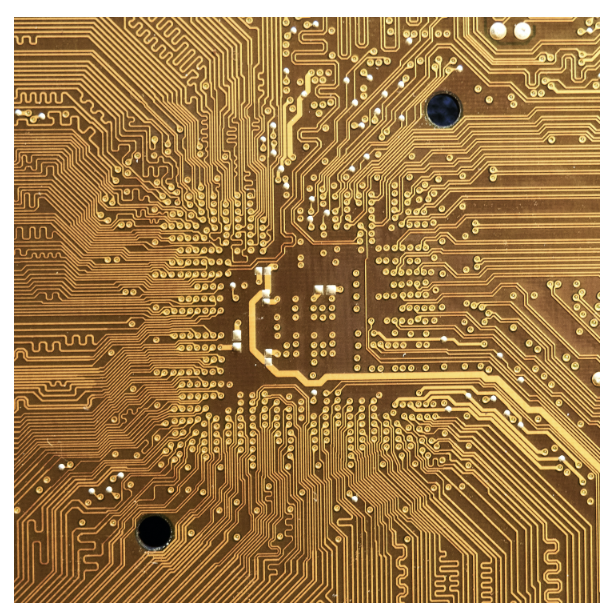

## 1. Hamiltonian Simulation
  In quantum mechanics, time evolution of the wave function $|\psi(t)\rangle$ is governed by the Schr$\ddot{o}$dinger equation,
  \begin{equation}
    i\hbar\frac{\mathrm{d}}{\mathrm{d}t}|\psi(t)\rangle=H(t)|\psi(t)\rangle
  \end{equation}
  For $H$ independent of time, the solution is:
  \begin{equation}
    |\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle
  \end{equation}
  Many natural Hamiltonians have the form of a sum of terms, common expamles include:
  - A particle in a potential: $H=\frac{p^2}{2m}+V(x)$
  - A $k$-local Heisenberg spin model: $H=-J \sum_{j=1}^N \sigma_j \sigma_{j+1}-h \sum_{j=1}^N \sigma_j$
  
  For numerical example, we choose Heisenberg model on a $2\times 3$ lattice. Without loss of generality, we assume there is no external magnetic field ($h=0$), and the interaction length equals unit ($J=1$).
  
  The Hamiltonian is $H = -\sum_{<i,j>}X_iX_j+Y_iY_j+Z_iZ_j$, where $X_i, Y_i$, and $Z_i$ are Pauli operators acting on the $i$-th spin, where the summation is over all neighboring spin pairs. We decompose the Hamiltonian into tree interaction terms: $H = H_1+H_2+H_3$, respectively represented by yellow, green, and red bonds. 
  
  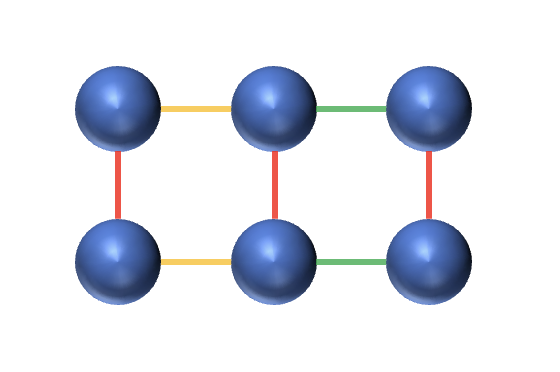
  
 In the following code, "np.kron" means tensor product between Pauli Matrices under the basis of spins.

In [2]:
import numpy as np
from scipy.linalg import kron, expm, norm
import matplotlib.pyplot as plt

# Pauli Matrices
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[0,1]])

# System Size: two L-length Single Chains
L = 3
N = 2 * L

# Construct Local Hamiltonians: H1, H2, and H3
H1 = - sum(kron(kron(op, op), np.eye(2**(L+1))) + kron(kron(np.eye(2**L), kron(op, op)), np.eye(2)) for op in [X, Y, Z])
H2 = - sum(kron(kron(np.eye(2),kron(op, op)), np.eye(2**L)) + kron(np.eye(2**(L+1)), kron(op,op)) for op in [X, Y, Z])
H3 = - sum(kron(kron(kron(kron(np.eye(2**i), op), np.eye(2**(L-1))), op), np.eye(2**(L-1-i))) for i in range(0,L) for op in [X, Y, Z])

# Construct Total Hamiltonian
H = H1 + H2 + H3

### 1.1 Quantum Circuit: why we need to break Hamiltonian into local terms

In quantum computing, we generally utilize subsets consisting of few single or two-qubit gates to approximate any unitary operation. 

You've probably heard some common gate elements such as **Control-NOT, Rotation-Pauli, Hardamard** and so on. On top of that, we can simulate tensor product of Pauli matrix. For instance, the following figure shows "unit" quantum circuit for implementing $e^{-i(Z_1Z_2Z_3\cdot\Delta t)}$:

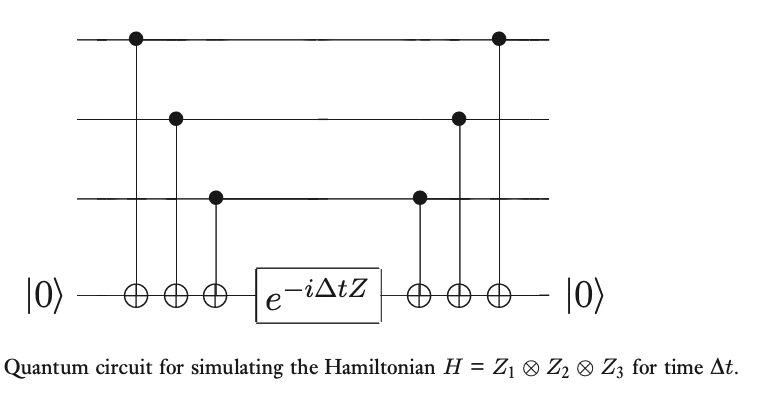

If we could analyse the relationship between original time-evolution operator and "unit" quantum circuit as the figure above, in principle we could simulate many natural Hamiltonians. In fact, there are following mathematical theorems in a nutshell: 

### 1.2 Product Formula
#### 1.2.1 Lie-Trotter Formula
In Lie algebra, for possibly *noncommutative* operator $X$ and $Y$, the product of their exponential does not behave that simply according to **Baker–Campbell–Hausdorff formula**:
  \begin{gather}
    e^Xe^Y=e^Z\\
    Z=X+Y+\frac{1}{2}[X,Y]+\frac{1}{12}[X,[X,Y]]-\frac{1}{12}[Y,[X,Y]]+\cdots
  \end{gather}
  For *Hamiltonian* with local interactions, $H=\sum_{k=1}^L H_k$, only when $[H_j,H_k]=0$ for all j,k could we split the time-evolution operator as products:
  \begin{equation}
    e^{-iHt}=e^{-iH_1t}e^{-iH_2t}\ldots e^{-iH_Lt}
  \end{equation}
  However, even in general cases where the term do not commute with each other, an enlightening idea is splitting time into segments, called **Lie formula** or **Trotterization**:
  \begin{equation}
    e^{-i(H_1+H_2+\ldots H_L)t}=\lim_{r\rightarrow\infty}(e^{-iH_1t/r}e^{-iH_2t/r}\cdots e^{-iH_L t/r})^r
  \end{equation} 

In [3]:
# System size: N, Local Hamlitonians: H_list
def Lie_Trotter(N, H_list, t_step, r):
    U = np.eye(pow(2,N))
    U_step = np.eye(pow(2,N))
    for H_local in H_list:
        U_step = U_step @ expm(-1j * H_local * t_step)
    for i in range(r):
        U = U @ U_step
    return U

#### 1.2.2 Trotter-Suzuki Formula
  By Taylor's theorem we can calculate the error bounds by straightforward algebra:
  \begin{gather}
    e^{-i(A+B)t}=e^{-iAt}e^{-iBt}+\mathcal{O}(t^2)\\
    e^{-i(A+B)t}=e^{-iAt/2}e^{-iBt}e^{-iAt/2}+\mathcal{O}(t^3)
  \end{gather}
  Generally, for *Hamiltonian* with $L$ terms, one could define recursively:
  \begin{gather}
    S_{1}(t):=e^{-i H_{1} t} e^{-i H_{2} t} \cdots e^{-i H_{L} t}=\prod_{l}^{\longrightarrow} e^{-i H_{l} t},
    S_{2}(t) :=\prod_{l}^{\longrightarrow} e^{-i H_{l} t / 2} \prod_{l}^{\longleftarrow} e^{-i H_{l} t / 2},\\
    S_{2 k}(t):=S_{2 k-2}^2\left(u_k t\right) S_{2 k-2}\left(\left(1-4 u_k\right) t\right) S_{2 k-2}^2\left(u_k t\right)=\prod_{s=1}^{S} \prod_{l=1}^{L} e^{-i t c_{(v, l)} H_{\pi_v(l)}},\\
    u_{k}:=\frac{1}{4-4^{1 /(2 k-1)}},~S=2 \cdot 5^{k-1}.
  \end{gather}
  Thus we have a very significant result called *Trotter Suzuki formula* [[5]](#3.-Reference), p-order expansion satisfies:
  \begin{equation*}
    \|{S_p(t)-e^{-iHt}}\| = \mathcal{O}(t^{p+1}).
  \end{equation*}

In [4]:
# 2-order Trotter-Suzuki Decomposition
def Trotter_Suzuki_2(N, H_list, t_step, r):
    U = np.eye(pow(2,N))
    U_step = np.eye(pow(2,N))
    for H_local in H_list:
        U_step = U_step @ expm(-1j * H_local * t_step / 2)
    for H_local in reversed(H_list):
        U_step = U_step @ expm(-1j * H_local * t_step / 2)
    for i in range(r):
        U = U @ U_step
    return U

In [5]:
# Define p-order Trotter-Suzuki Decomposition by Recursion
def Trotter_Suzuki(N, H_list, t_step, r, p):
    if p == 1:
        return Lie_Trotter(N, H_list, t_step, r)
    elif p == 2:
        return Trotter_Suzuki_2(N, H_list, t_step, r)
    else:
        u = 1/(4-pow(4,1/(p-1)))
        return Trotter_Suzuki(N, H_list, u * t_step, r, p-2) @ Trotter_Suzuki(N, H_list, u * t_step, r, p-2) @ Trotter_Suzuki(N, H_list, (1-4*u) * t_step, r, p-2) @ Trotter_Suzuki(N, H_list, u * t_step, r, p-2) @ Trotter_Suzuki(N, H_list, u * t_step, r, p-2)

If we measure the Trotter Error by spectral norm, let's change the timestep and Trotter number, plot the error using 2-order Trotter-Suzuki formula. We could see that the **cubic function** fits the error very well, as the theory predicted.

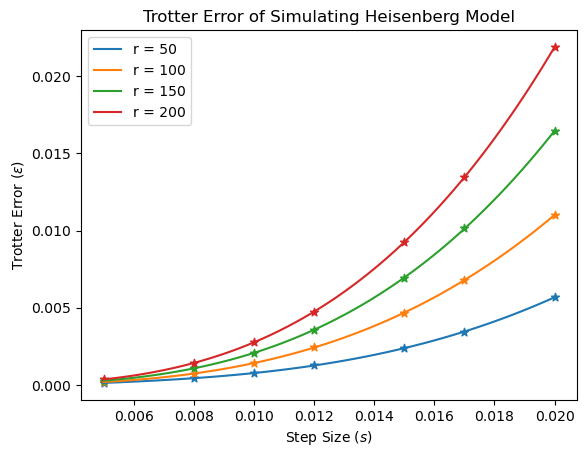

In [6]:
fig,ax = plt.subplots()

# Timestep and Trotter Number
timestep_list = [0.005, 0.008, 0.010, 0.012, 0.015, 0.017, 0.020]
pivot = np.linspace(min(timestep_list), max(timestep_list), 100)
trotter_number_list = [50, 100, 150, 200]

# Plot
for r in trotter_number_list:
    trotter_error = []
    for t_step in timestep_list:
        trotter_error.append(norm(expm(-1j * H * t_step * r) - Trotter_Suzuki_2(2*L, [H1, H2, H3], t_step, r),2))
    coefficients = np.polyfit(timestep_list, trotter_error, 3)
    poly = np.poly1d(coefficients)
    ax.scatter(timestep_list, trotter_error, marker = '*')
    ax.plot(pivot, poly(pivot), label = "r = {r}".format(r = r))

ax.set_title("Trotter Error of Simulating Heisenberg Model")
ax.set_xlabel("Step Size ($s$)")
ax.set_ylabel("Trotter Error ($\epsilon$)")
ax.legend()
plt.show()

### 1.3 qDRIFT Algorithm
Since the permutation of local terms in Trotter-Suzuki Formula is chosen arbitrarily. Without loss of generality, In 2018, Campbell imported randomness to seek possible improvement [[6]](#3.-Reference).

\begin{equation*}
\begin{aligned}
&\begin{aligned}
& \textbf { Input:} \text{ Hamiltonian } H=\sum_{l=1}^L H_l \text { with interaction strength } h_{\Lambda}=\sum_l\left\|H_l\right\| \text {, evolution time } t \text {, } \\
& \text { and number of steps } r \\
& \text { 1: At each time interval } t / r \text { : evolve a random term in Hamiltonian } V_i=e^{-i(t / r) X_i} \text { with } X_i \\
& \quad \text { randomly chosen as } \frac{h_\Lambda}{\left\|H_l\right\|} H_l \text { with probability }\left\|H_l\right\| / h_{\Lambda} \\
& \textbf { Output:} \text{ The unstructured (randomly generated) product formula } V(r)=V_r \ldots V_1
\end{aligned}
\end{aligned}
\end{equation*}

In [7]:
# qDRIFT Algorithm
def U_qDRIFT(N, H_list, t, step_number):
    norm_list = []
    for H_l in H_list:
        norm_list.append(norm(H_l, 2))

    total_sum = sum(norm_list)
    
    unitary_list = []
    for index in range(len(H_list)):
        unitary_list.append(expm(-1j * (total_sum / norm_list[index]) * H_list[index] * (t / step_number)))

    probabilities = norm_list/total_sum

# Randomly Generate
    U_qDrift = np.eye(2**(N))
    for i in range(step_number):
        selected_index = np.random.choice(len(probabilities), p = probabilities)
        U_qDrift = U_qDrift @ unitary_list[selected_index]
    return U_qDrift


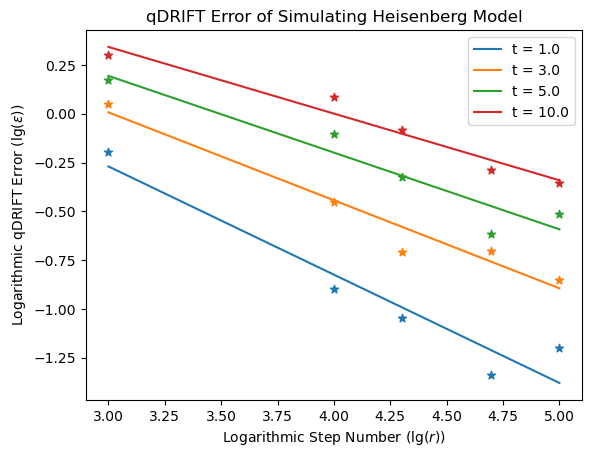

In [8]:
fig,ax = plt.subplots()

# Evolution Time and Random Walk Step Number
step_number_list = [1000, 10000, 20000, 50000, 100000]
pivot = np.linspace(min(np.log(step_number_list)/np.log(10)), max(np.log(step_number_list)/np.log(10)), 100)
t_list = [1.0, 3.0, 5.0, 10.0]

for t in t_list:
    qDRFIT_Error = []
    for step_number in step_number_list:
        qDRFIT_Error.append(norm(expm(-1j * H * t) - U_qDRIFT(2*L, [H1, H2, H3], t, step_number),2))
    coefficients = np.polyfit(np.log(step_number_list)/np.log(10), np.log(qDRFIT_Error)/np.log(10), 1)
    poly = np.poly1d(coefficients)
    ax.scatter(np.log(step_number_list)/np.log(10), np.log(qDRFIT_Error)/np.log(10), marker = '*')
    ax.plot(pivot, poly(pivot), label = "t = {t}".format(t = t))
        
ax.set_title("qDRIFT Error of Simulating Heisenberg Model")
ax.set_xlabel("Logarithmic Step Number ($\lg(r)$)")
ax.set_ylabel("Logarithmic qDRIFT Error ($\lg(\epsilon)$)")
ax.legend()
plt.show()

The slopes of the lines are all almost -1/2, which roughly verify the theory: **qDRIFT_Error ~ $\mathbf{\frac{1}{\sqrt{r}}}$**.

What's worth mentioning, the qDRIFT algorithm is easy to be mistaken for randmom permutation Trotter-Suzuki algorithm [[7]](#3.-Reference), which simply averages the time-evolution quantum channel over all permutation of local Hamiltonians.

  ### 1.4 More About Efficient Simulation
  We say $H$ can be *effeciently simulated* if for any $t>0,\epsilon>0$, there is a quantum circuit $U$
  consisting of poly$(n,t,1/\epsilon)$ gates such that $\Vert U-e^{-iHt}\Vert\leqslant\epsilon$.
  
  Generally, the problem of simulating Hamiltonians is **BQP-hard**.
  
  Up to now, mainstream algorithms for quantum simulation include:
  1. **Product Formula** [[3]](#3.-Reference): the most straightforward approach first proposed. 
  2. **Randomized Product Formula** [[6, 7]](#3.-Reference): randomly permuting terms in product formula & the qDRIFT algorithm.
  3. **Truncated Taylor Series** [[8]](#3.-Reference): an alternative approach that leverages *LCU* achieves complexity poly$(\log(1/\epsilon))$.
  4. **Quantum Singnal Processing** [[9]](#3.-Reference): an approach based on qubitization and block-encoding with an optimal complexity tradeoff.

## 2. Variational Quantum Eigensolver

The variational quantum eigensolver (VQE) [[10]](#3.-Reference) is a method that uses a hybrid quantum-classical computational approach to find eigenvalues of a Hamiltonian.

### 2.1 Schematic of VQE
It starts with a reasonable assumption about the form of the target wave function. A trial wave function or ansatz is constructed with adjustable parameters, followed by the design of a quantum circuit capable of realizing this
ansatz. The ansatz parameters are then variationally adjusted until the expectation
value of the electronic Hamiltonian is minimized:

$$E \leq \frac{\langle\psi(\vec{\theta})\left|\hat{H}\right| \psi(\vec{\theta})\rangle}{\langle\psi(\vec{\theta}) | \psi(\vec{\theta})\rangle}$$

Here is a schematic of variational quantum eigensolver (VQE) that minimizes the energy of Fermionic Hamiltonian $\langle \psi(\vec{\theta}|\hat{H}|\psi(\vec{\theta})\rangle$. It uses classical computing resources denoted by green color and quantum computing resources denoted
by blue. A simulation starts by constructing wavefunction ansatz with a set of initial parameter. Then the quantum computer prepares the trial state by applying parameterized unitary on Hatree-Fock wavefunction, and at iteration $k$, the energy of the Hamiltonian is computed by measuring every Hamiltonian term $\langle \psi(\vec{\theta_k}|P_j|\psi(\vec{\theta_k})\rangle$ and adding them on a classical computer. Next, the clasical optimization algorithm updates the parameter and feedbacks to the quantum computer. Finally the quantum computer generates a new state and goes round.

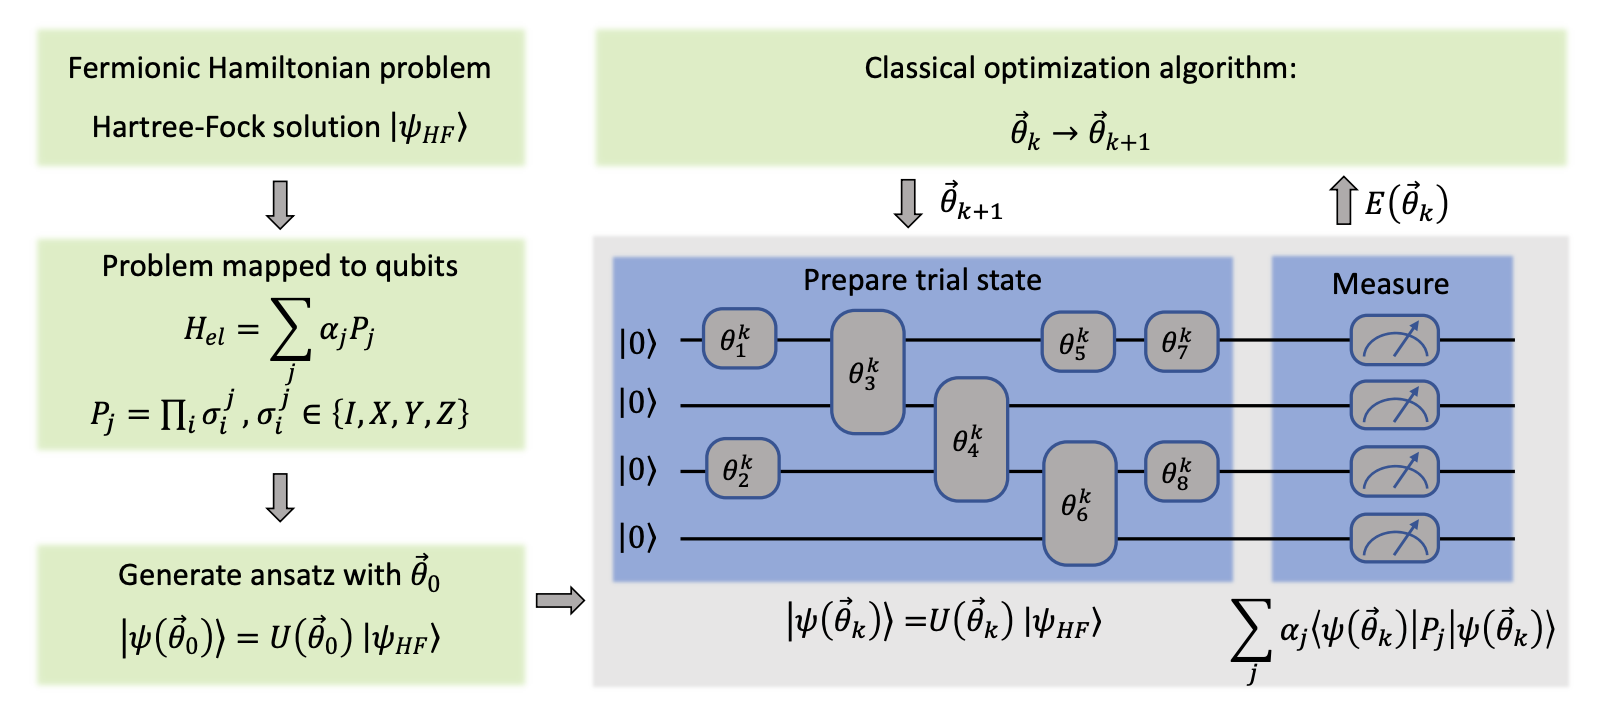

We use TenCirChem from Tencent to implement Quantum Chemistry Computation: https://github.com/tencent-quantum-lab/TenCirChem

In the following code, h4 represents chain consisting of 4 H atoms, the UCCSD is a wavefunction ansatz for optimization, which is chemistry-inspired and represents a unitary version of the classical non-unitary CCSD method.

In [ ]:
! pip install tencirchem

In [12]:
from tencirchem import UCCSD, M

d = 0.8
# Distance Unit is Angstrom
h4 = M(atom=[["H", 0, 0, d * i] for i in range(4)])

# Configuration
uccsd = UCCSD(h4)
# Calculate and Returns Energy
uccsd.kernel()
# Analyze Result
uccsd.print_summary(include_circuit=True)

################################ Ansatz ###############################
 #qubits  #params  #excitations initial condition
       8       11            18               RHF
############################### Circuit ###############################
 #qubits  #gates  #CNOT  #multicontrol  depth  #FLOP
       8     146     98             10     78 506688
############################### Energy ################################
       energy (Hartree)  error (mH) correlation energy (%)
HF            -2.121387   46.173788                 -0.000
MP2           -2.151794   15.766505                 65.854
CCSD          -2.167556    0.004979                 99.989
UCCSD         -2.167546    0.014384                 99.969
FCI           -2.167561    0.000000                100.000
############################# Excitations #############################
      excitation configuration     parameter  initial guess
0         (6, 4)      01100011 -6.291323e-03       0.000000
1         (2, 0)      00110110 -

### 2.2 Quantum Circuit: trial state preparation

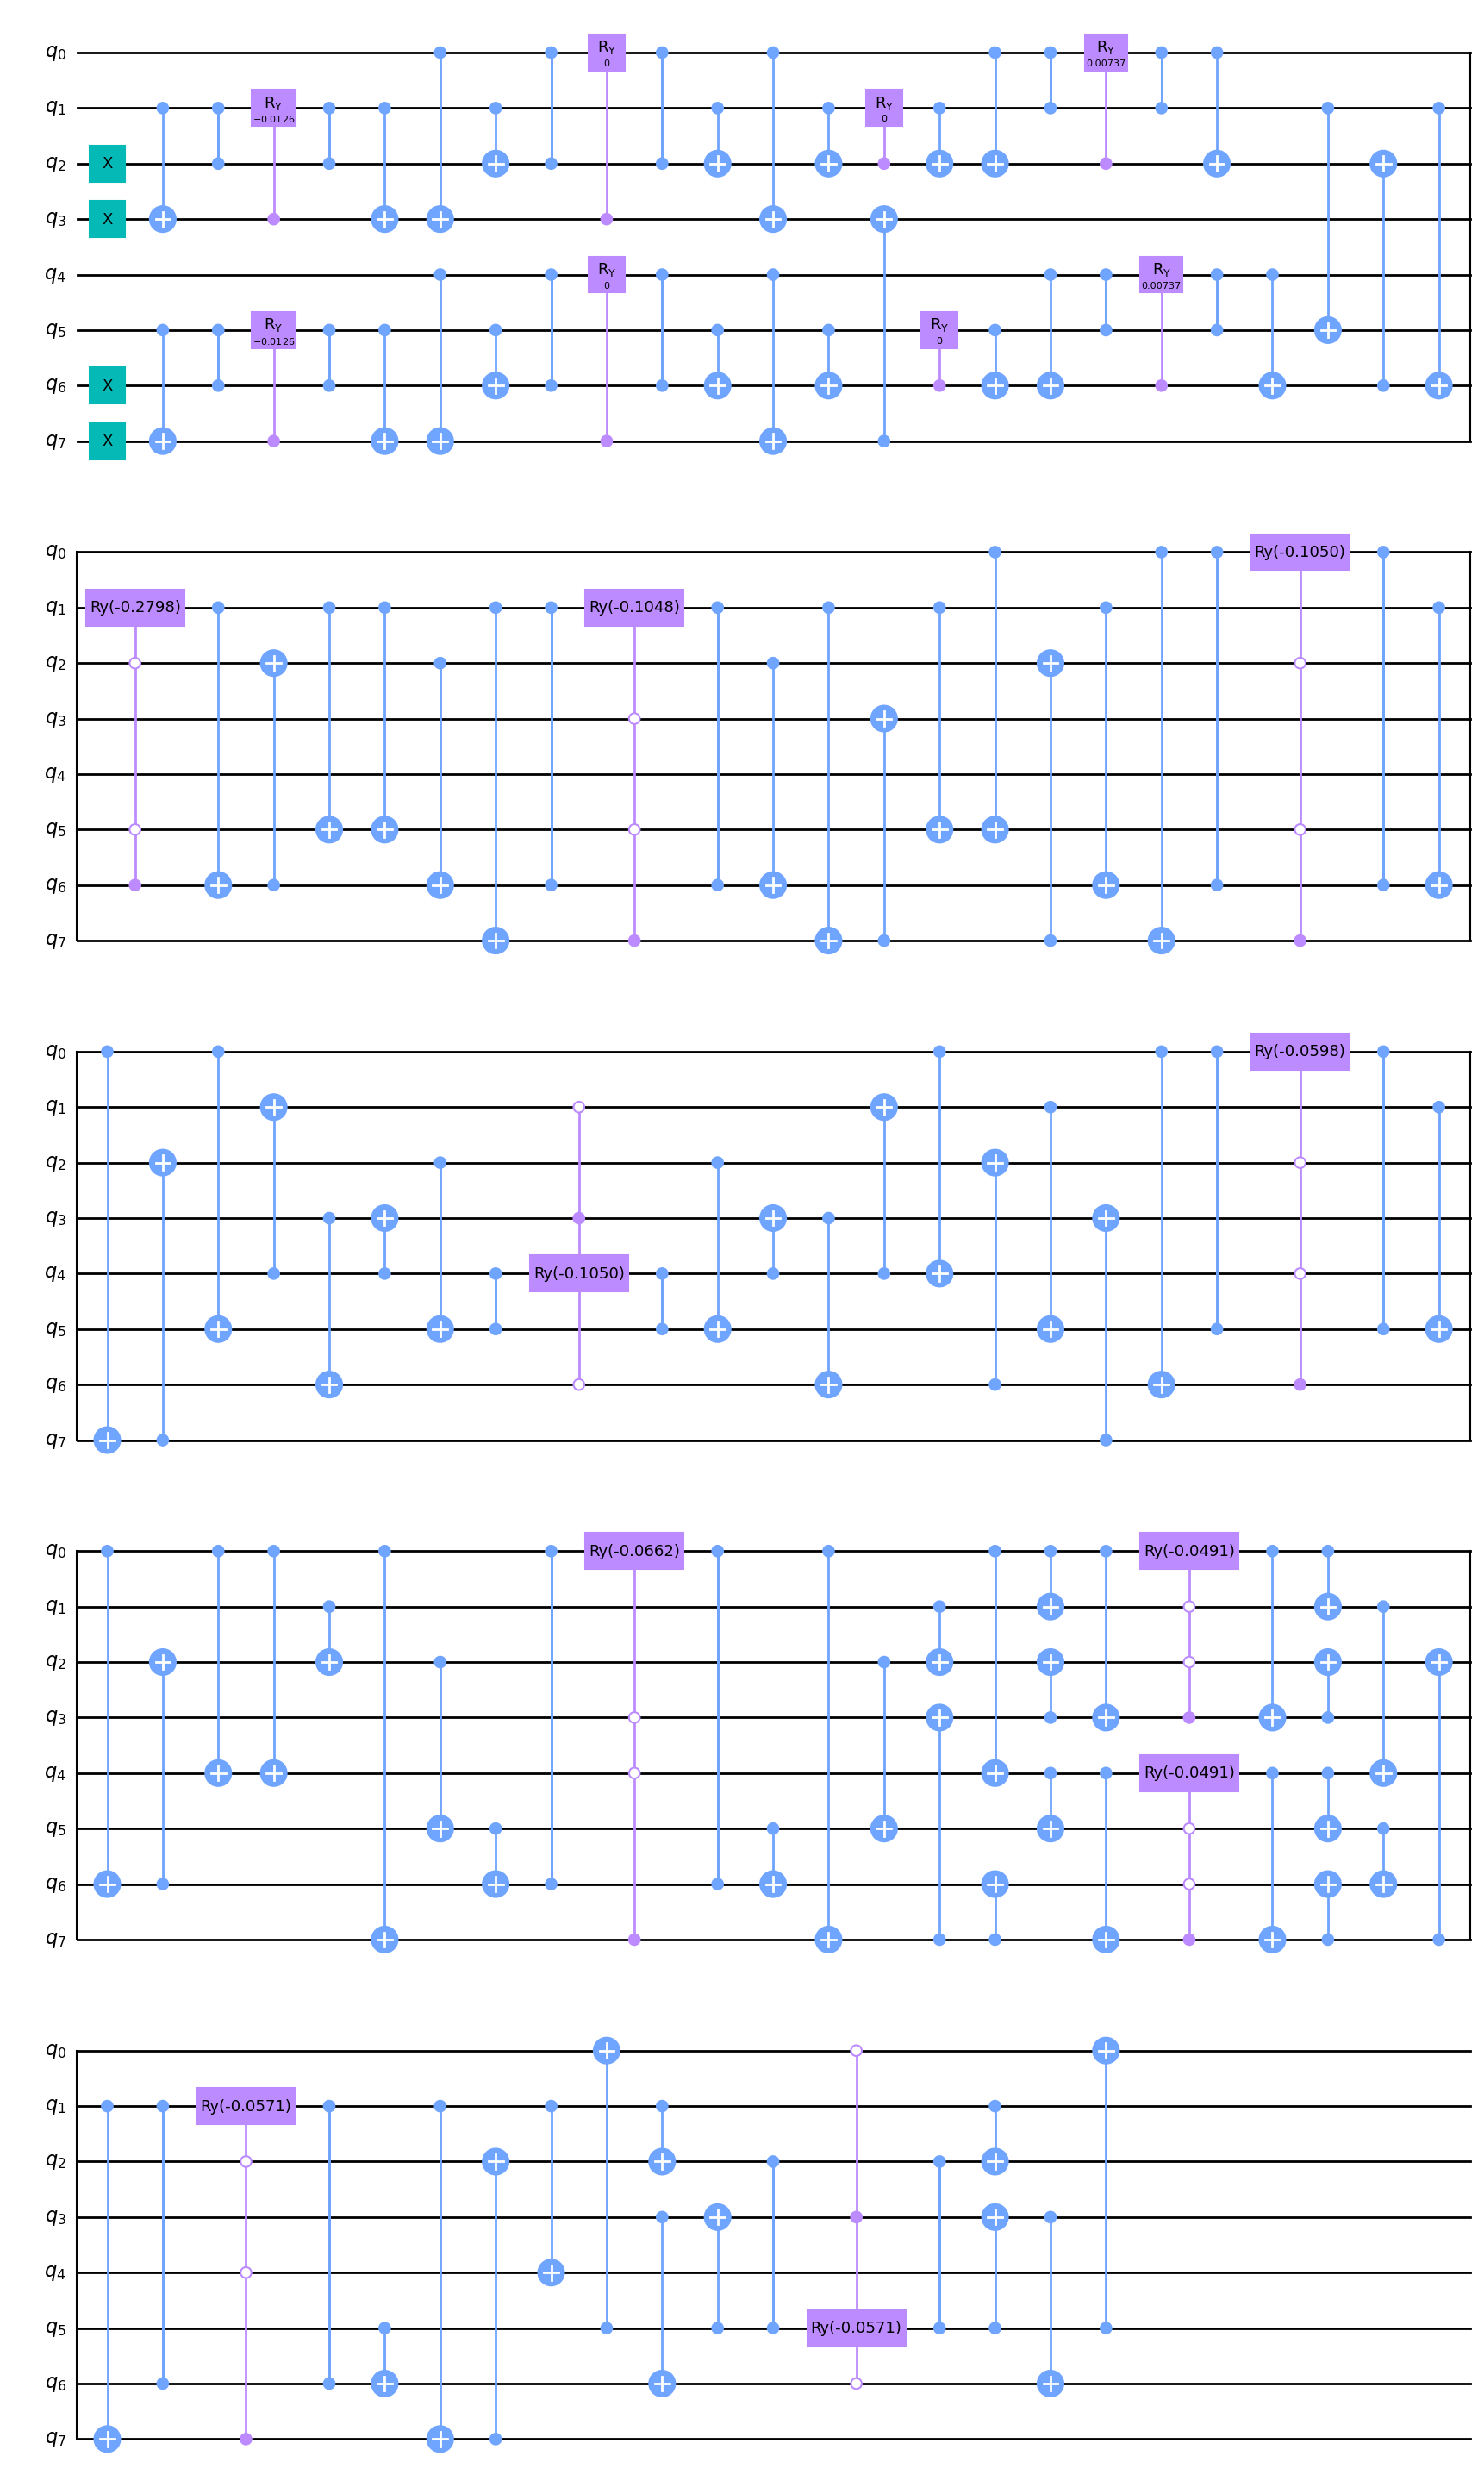

In [13]:
# Display the Quantum Circuit of the Trial State Preparation
circuit = uccsd.get_circuit()
circuit.draw(output="mpl")

## 3. Reference
1. Peter W. Shor, *Polynomial-time algorithms for prime factorization and discrete logarithms on a quantum computer*, SIAM Journal on Computing **26** (1997), no. 5, 1484–1509, [quant-ph/9508027](https://arxiv.org/abs/quant-ph/9508027), preliminary version in FOCS 1994.
2. Lov K. Grover, *Quantum mechanics helps in searching for a needle in a haystack*, Physical Review Letters **79** (1997), no. 2, 325–328, [quant-ph/9706033](https://arxiv.org/abs/quant-ph/9706033), preliminary version in STOC 1996.
3. Richard P. Feynman, *Simulating physics with computers*, International Journal of Theoretical Physics **21** (1982), no. 6, 467-488.
4. Seth Lloyd, *Universal quantum simulators*, Science **273** (1996), 1073-1078.
5. Masuo Suzuki, *Fractal decomposition of exponential operators with applications to many-body theories and Monte Carlo simulations*, Physics Letter **A** (1990), 319-323.
6. Earl Campbell, *Random compiler for fast hamiltonian simulation*, Physical Reivew Letters **123** (2019), no. 7, 070503, [arXiv:1811.08017](https://arxiv.org/abs/1811.08017).
7. Andrew M. Childs, Aaron Ostrander, and Yuan Su, *Faster quantum simulation by randomization*, Quantum **3** (2019), 182, [arXiv:1805.08385](https://arxiv.org/abs/1805.08385).
8. Dominic W. Berry, Andrew M. Childs, Richard Cleve, Robin Kothari, and Rolando D. Somma, *Simulating hamiltonian dynamics with a truncated taylor series*, Physical Review Letters **114** (2015), no. 9, 090502, [arXiv:1412.4687](https://arxiv.org/abs/1412.4687).
9. Guang Hao Low and Isaac L. Chuang, *Optimal hamiltonian simulation by quantum signal processing*, Physical Review Letters **118** (2017), no. 1, 010501, [arXiv:1606.02685](https://arxiv.org/abs/1606.02685).
9. Dmitry A. Fedorov, Bo Peng, Niranjan Govind, Yuri Alexeev, *VQE method: a short survey and recent developments*, Materials Theory **6** (2022), [arXiv:2103.08505](https://arxiv.org/abs/2103.08505).